# Synthetic data test: Effect of random noise on the solution

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Create the model and noise-free data

In [2]:
region = [0, 35e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (15e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly_noiseless = (
    sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
)

## Make noisy grids with different noise levels

In [3]:
noise_levels = np.arange(0, 31, 2.5)
noisy_data = {}
for noise in noise_levels:
    magnetic_anomaly = magnetic_anomaly_noiseless + np.random.default_rng(42).normal(
        0, noise, size=magnetic_anomaly_noiseless.shape
    )
    # Make a grid and calculate derivatives
    # Can't have the height as a coordinate because of a problem with xrft
    data = vd.make_xarray_grid(
        coordinates[:2],
        (magnetic_anomaly, coordinates[-1]),
        data_names=["field", "height"],
    )
    data["deriv_east"] = hm.derivative_easting(data.field)
    data["deriv_north"] = hm.derivative_northing(data.field)
    pad_width = {
        "easting": data.easting.size // 3,
        "northing": data.northing.size // 3,
    }
    padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
    data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
    # Add back the height
    data = data.assign_coords(height=data.height)
    noisy_data[noise] = data

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


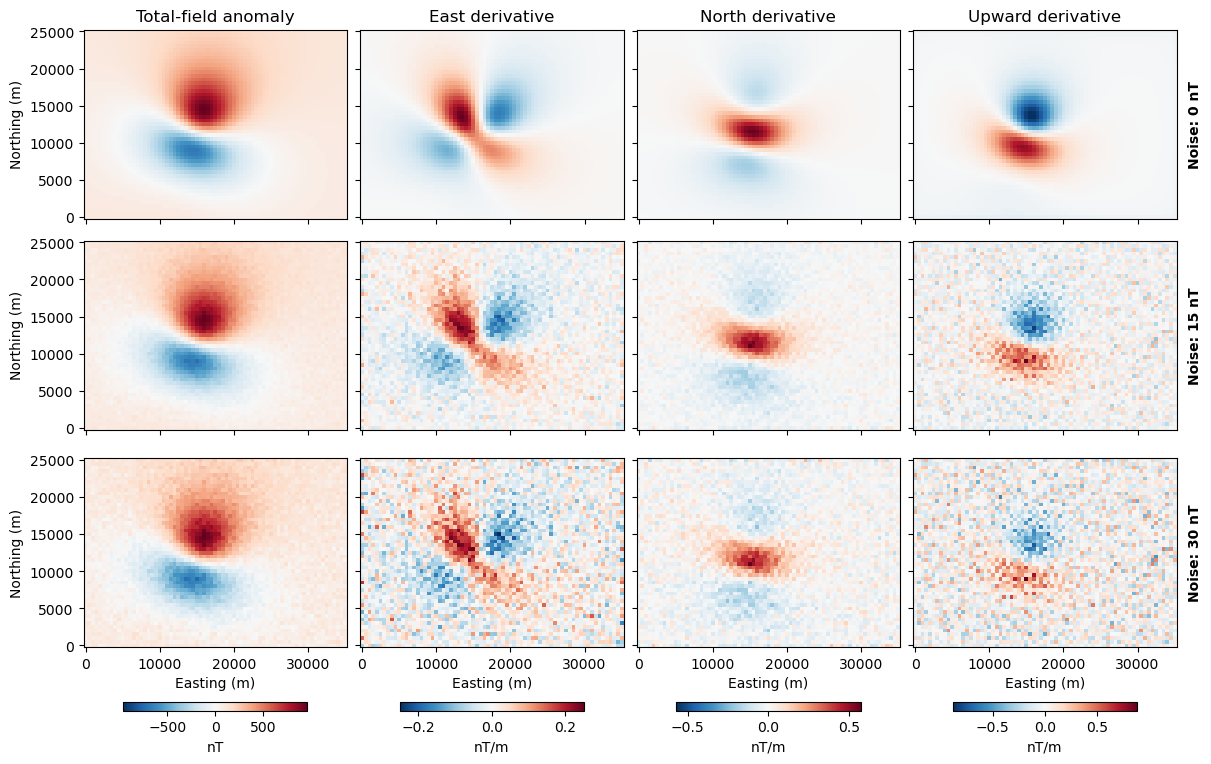

In [4]:
fig, axes = plt.subplots(
    3, 4, figsize=(12, 7.5), layout="constrained", sharex=True, sharey=True
)
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
titles = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
noise_to_plot = [0, 15, 30]
for i, noise in enumerate(noise_to_plot):
    for field, ax in zip(titles, axes[i, :].ravel()):
        if i == axes.shape[0] - 1:
            kwargs = dict(
                add_colorbar=True,
                cbar_kwargs=dict(
                    orientation="horizontal", aspect=20, shrink=0.7, label=units[field]
                ),
            )
        else:
            kwargs = dict(add_colorbar=False)
        noisy_data[noise][field].plot.pcolormesh(ax=ax, add_labels=False, **kwargs)
        ax.set_aspect("equal")
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, noise in zip(axes[:, -1], noise_to_plot):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"Noise: {noise} nT", fontweight="bold", labelpad=8)
for ax, field in zip(axes[0, :], titles):
    ax.set_title(titles[field])
plt.show()

## Run the Euler Inversion and Deconvolution with a single window

In [5]:
estimates_ei = {}
estimates_ei_weights = {}
estimates_ed = {}
for noise in noisy_data:
    data = noisy_data[noise]
    estimates_ei_weights[noise] = euler.EulerInversion(structural_index=3).fit_grid(
        data, weights=(1, 0.1, 0.1, 0.01)
    )
    estimates_ei[noise] = euler.EulerInversion(structural_index=3).fit_grid(
        data, weights=(1, 1, 1, 1)
    )
    estimates_ed[noise] = euler.EulerDeconvolution(structural_index=3).fit_grid(data)

## Plot the data and the error in the position estimates

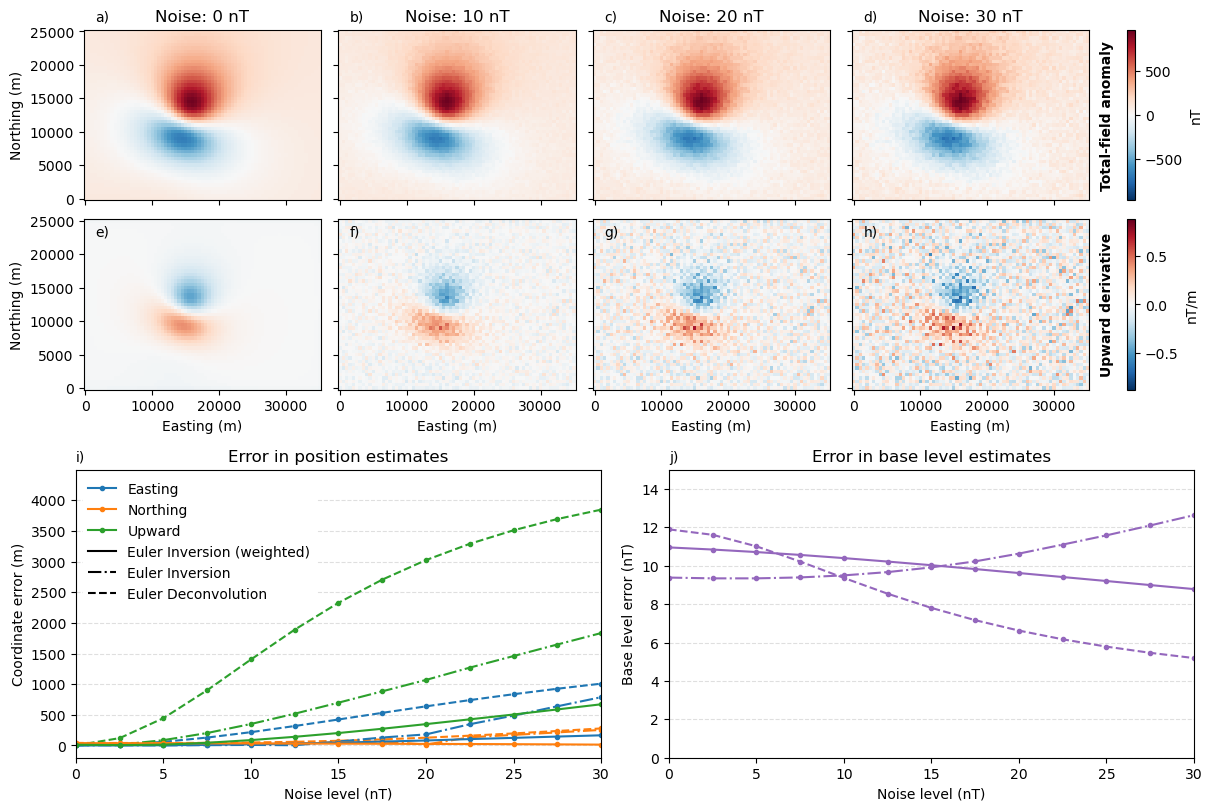

In [6]:
fig = plt.figure(figsize=(12, 8), layout="constrained")

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

figures = fig.subfigures(2, 1, height_ratios=[1.2, 1])

axes = figures[0].subplots(2, 4, sharey=True, sharex=True)

units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
titles = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
noise_to_plot = [0, 10, 20, 30]

for ax in axes.ravel():
    ax.set_aspect("equal")
for ax, label in zip(axes[0, :], "abcd"):
    ax.text(0.05, 1.05, f"{label})", transform=ax.transAxes)
for ax, label in zip(axes[1, :], "efgh"):
    ax.text(0.05, 0.9, f"{label})", transform=ax.transAxes)
scale = vd.maxabs(noisy_data[30].field)
for ax, noise in zip(axes[0, :], noise_to_plot):
    tmp = noisy_data[noise]["field"].plot.pcolormesh(
        ax=ax,
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
        add_labels=False,
        add_colorbar=False,
    )
figures[0].colorbar(tmp, ax=axes[0, -1], label="nT")
scale = vd.maxabs(noisy_data[30].deriv_up)
for ax, noise in zip(axes[1, :], noise_to_plot):
    tmp = noisy_data[noise]["deriv_up"].plot.pcolormesh(
        ax=ax,
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
        add_labels=False,
        add_colorbar=False,
    )
figures[0].colorbar(tmp, ax=axes[1, -1], label="nT/m")

for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, noise in zip(axes[0, :], noise_to_plot):
    ax.set_title(f"Noise: {noise} nT")
for ax, field in zip(axes[:, -1], ["field", "deriv_up"]):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(titles[field], fontweight="bold", labelpad=8)


ax1, ax2 = figures[1].subplots(1, 2)

for ax, label in zip((ax1, ax2), "ij"):
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)
for estimates, style in zip(
    [estimates_ed, estimates_ei, estimates_ei_weights], ["--", "-.", "-"]
):
    error_position = []
    error_baselevel = []
    for noise in estimates:
        ei = estimates[noise]
        error_position.append(np.abs(np.array(true_coordinates) - ei.location_))
        error_baselevel.append(base_level - ei.base_level_)
    error_position = np.array(error_position)

    (east,) = ax1.plot(
        noise_levels, error_position[:, 0], color=colors[0], linestyle=style, marker="."
    )
    (north,) = ax1.plot(
        noise_levels, error_position[:, 1], color=colors[1], linestyle=style, marker="."
    )
    (up,) = ax1.plot(
        noise_levels, error_position[:, 2], color=colors[2], linestyle=style, marker="."
    )
    (base,) = ax2.plot(
        noise_levels, error_baselevel, color=colors[4], linestyle=style, marker="."
    )
ax1.grid(axis="y", alpha=0.4, linestyle="--")
ax2.grid(axis="y", alpha=0.4, linestyle="--")
(inversion_weights,) = ax1.plot([], [], "-k")
(inversion,) = ax1.plot([], [], "-.k")
(deconv,) = ax1.plot([], [], "--k")
ax1.legend(
    [
        east,
        north,
        up,
        inversion_weights,
        inversion,
        deconv,
    ],
    [
        "Easting",
        "Northing",
        "Upward",
        "Euler Inversion (weighted)",
        "Euler Inversion",
        "Euler Deconvolution",
    ],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
ax2.set_ylim(0, 15)
ax1.set_ylim(-200, 4500)
ax1.set_yticks(np.arange(0, 4001, 500))
for ax in (ax1, ax2):
    ax.set_xlim(min(noise_levels), max(noise_levels))
    ax.set_xlabel("Noise level (nT)")
ax1.set_ylabel("Coordinate error (m)")
ax2.set_ylabel("Base level error (nT)")
ax1.set_title("Error in position estimates")
ax2.set_title("Error in base level estimates")


for dpi, res in zip([70, 300], ["", "-highres"]):
    fig.savefig(
        f"../paper/figures/synthetic-noise-levels{res}.png",
        dpi=dpi,
        bbox_inches="tight",
    )

plt.show()